# Aquapointer Density File Slicing Example

This is a demonstration of the `Slicing` module in Aquapointer, for processing 3D-RISM density files into useful objects, namely `DensityCanvas` objects. The properties of the resulting `DensityCanvas` objects include parameters, which are taken as inputs in the QUBO solution workflow.

In [1]:
from copy import deepcopy
import numpy as np
from numpy.linalg import norm
import scipy.ndimage as ndi
from aquapointer.analog.utils import detuning_scale_utils as dsu
from aquapointer.density_canvas.DensityCanvas import DensityCanvas
from aquapointer.slicing import density_file_to_grid, density_slices_by_plane_and_offsets, density_slices_by_planes, density_origin, density_point_boundaries
import matplotlib.pyplot as plt

### 1. Load the 3D-RISM density file into a [`grid`](https://griddataformats.readthedocs.io/en/latest/gridData/formats/OpenDX.html#) object, which can be converted into a numpy array and sliced into 2D arrays, which are then converted into density canvases.

In [2]:
grid = density_file_to_grid("../data/3D-RISM_densities/1NNC/prot_3drism.O.1.dx")

In [3]:
print(density_origin(grid))
print(density_point_boundaries(grid))

[ 6.694 -3.659 41.76 ]
[46.694 36.341 81.76 ]


## 2. Define slicing planes. 
One way to do this is by defining an array of 3 points and (optionally) offsets to create parallel slicing planes. 

In [4]:
points = np.array([[0, 0, 10], [1, 0, 10], [0, 1, 10]]) + np.array([density_origin(grid)] * 3)
canvases = density_slices_by_plane_and_offsets(grid, points=points, offsets=[10, 20])

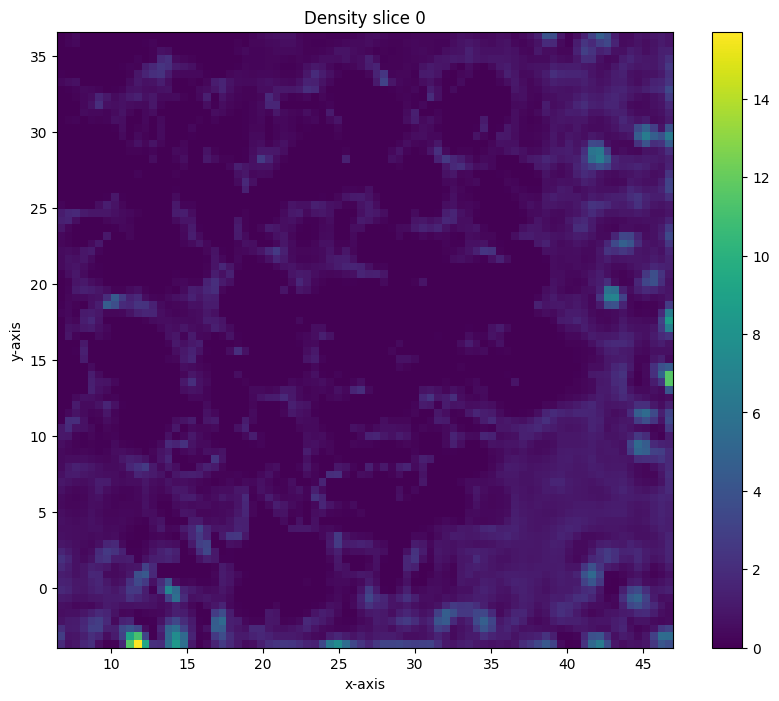

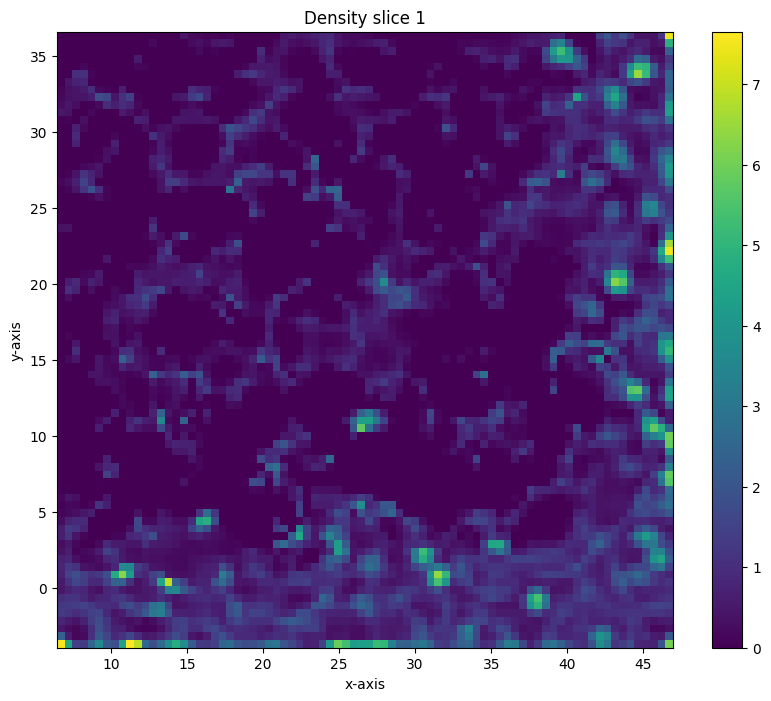

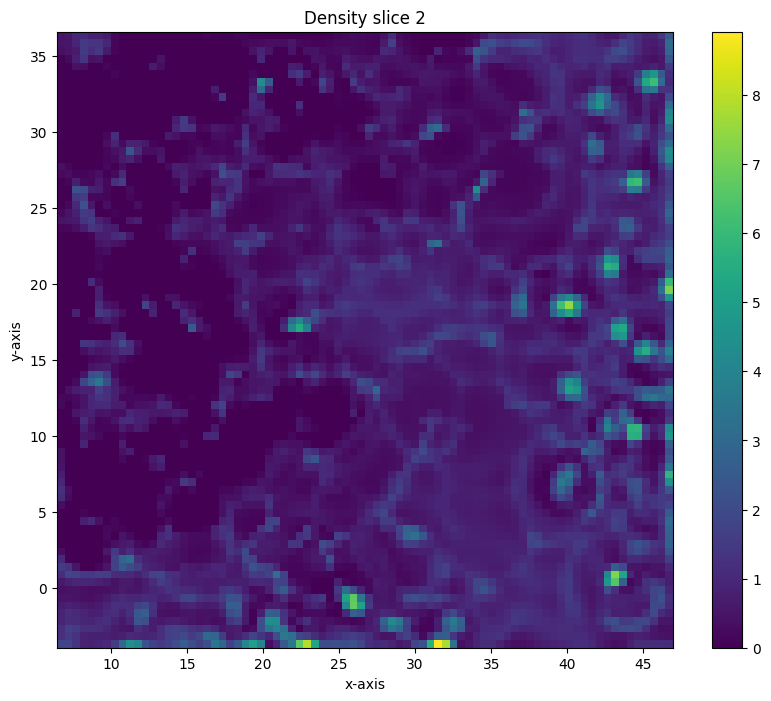

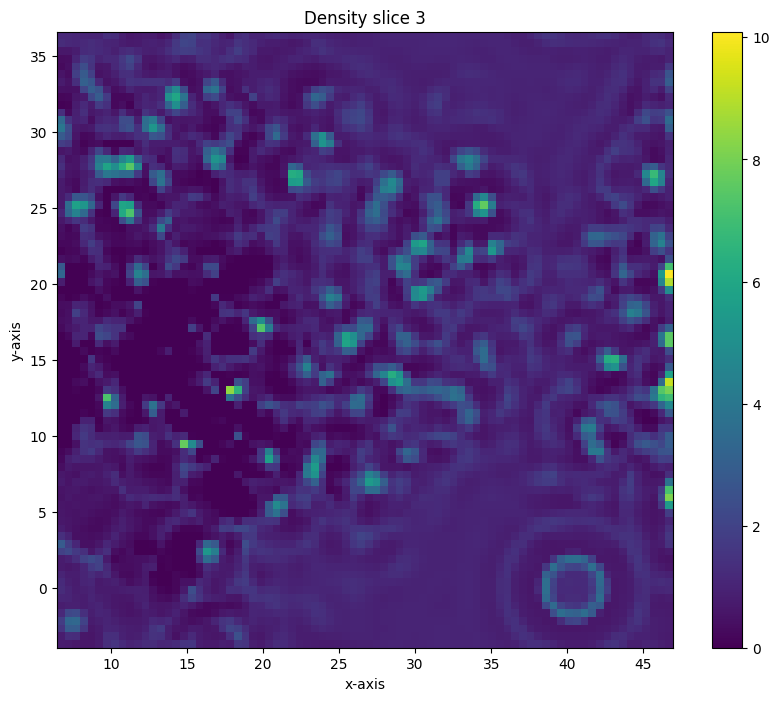

In [5]:
for c, canvas in enumerate(canvases):
    canvas.draw(title=f"Density slice {c}")

## 3. (Optional) Density canvases can be filtered by a user-defined filter function (or a function from another package, such as `scipy.ndimage.laplace`).

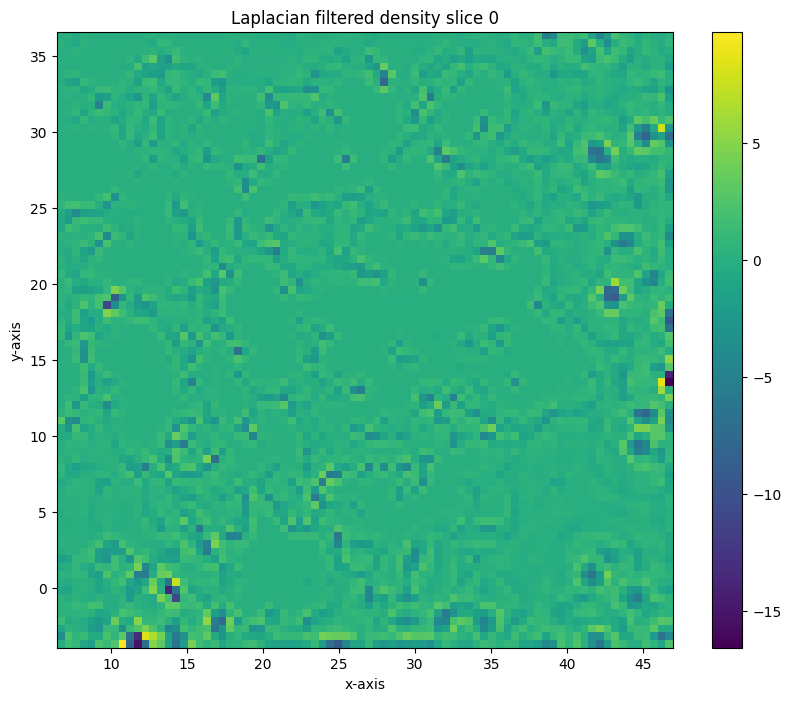

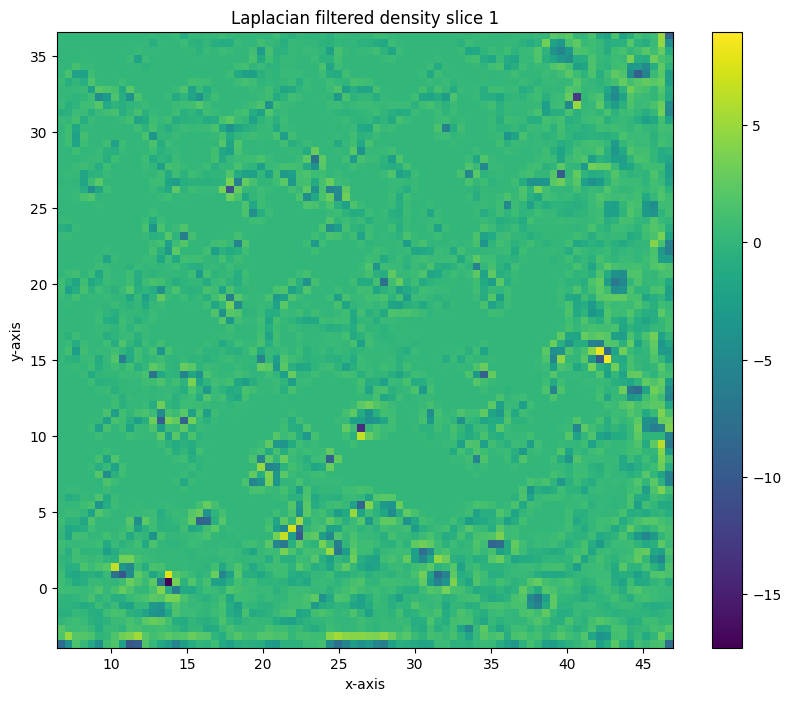

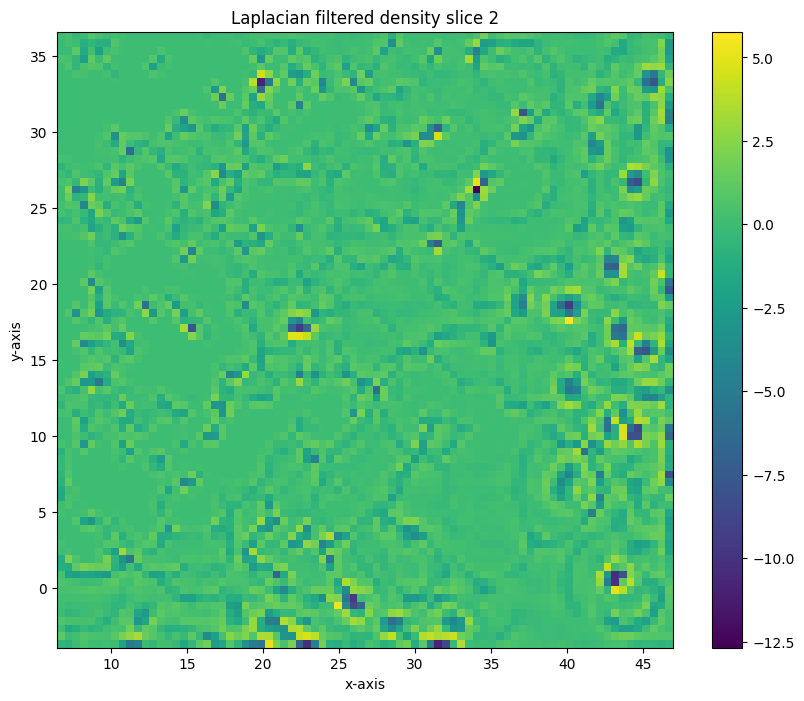

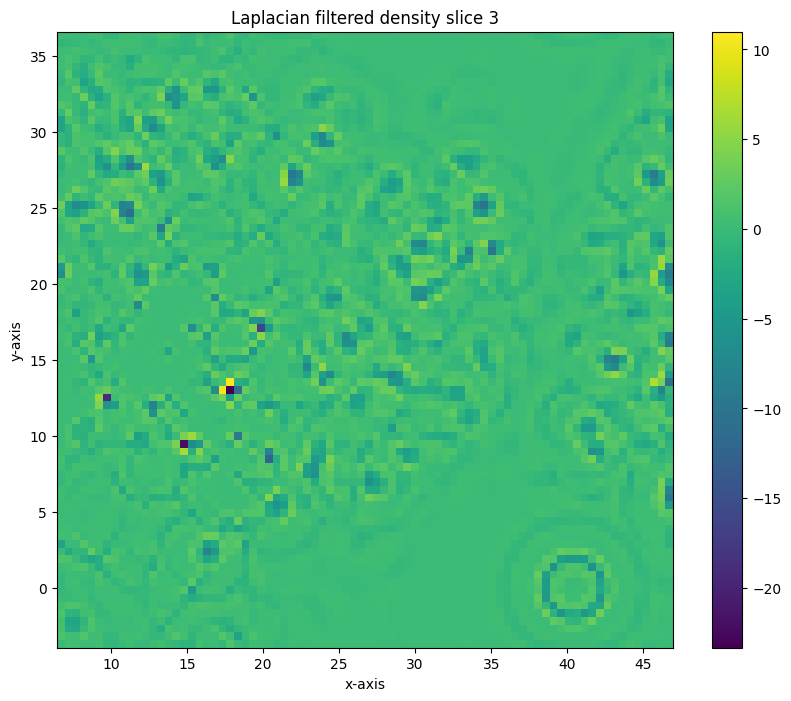

In [6]:
for c, canvas in enumerate(canvases):
    filtered = deepcopy(canvas)
    filtered.filter_density(filter_settings={"filter_function": ndi.laplace})
    filtered.draw(title=f"Laplacian filtered density slice {c}")

## 4. (Optional) Density canvases can be cropped to focus on a particular region. Just specify the center and the x and y dimensions of the bounding box 

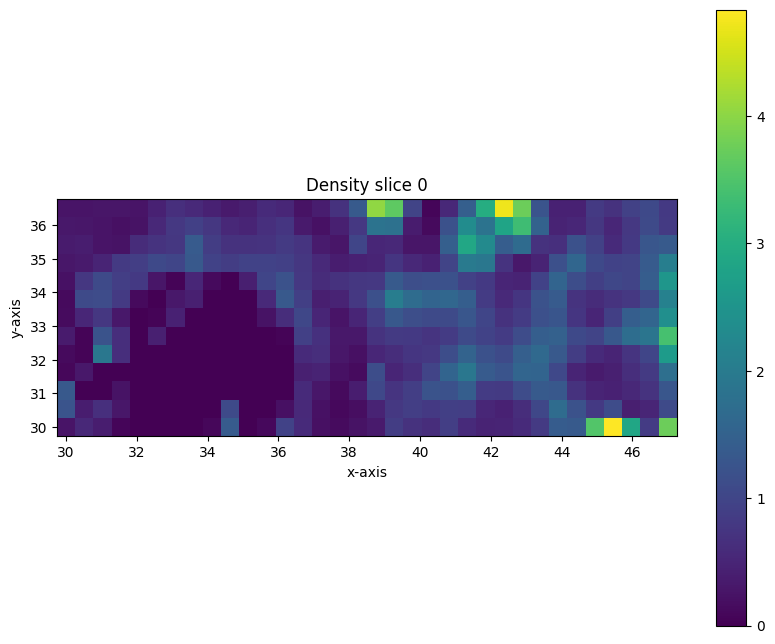

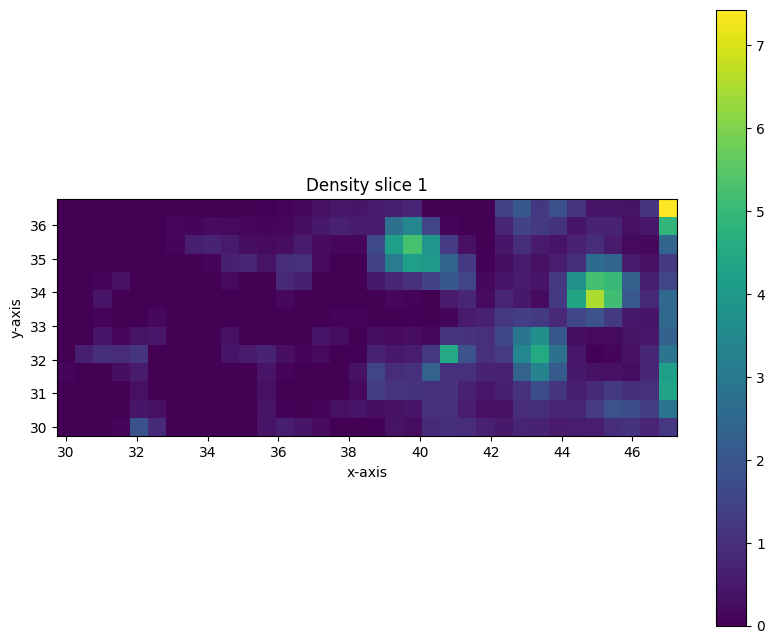

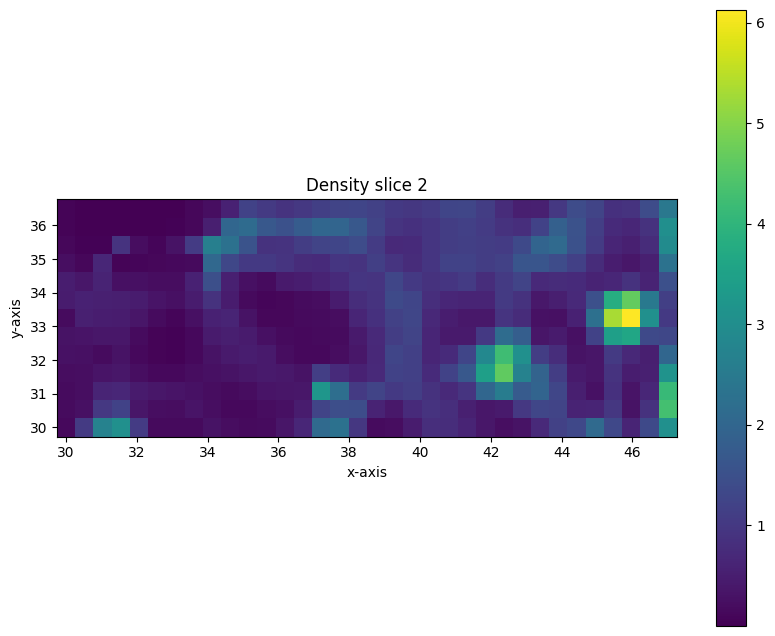

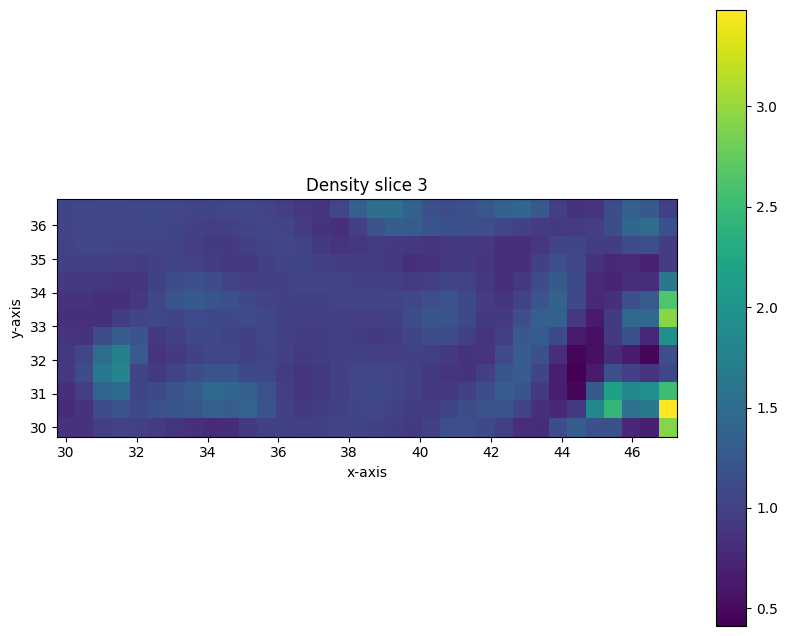

In [7]:
cropped_canvases = deepcopy(canvases)

for c, canvas in enumerate(canvases):
    cropped = deepcopy(canvas)
    cropped.crop_canvas((40, 40), (20, 20))
    cropped.draw(title=f"Density slice {c}")

Alternatively, it is possible to define slicing planes by a list of arrays containing the 3 point definition of each slicing plane.

In [8]:
og = density_origin(grid)
points_1nnc = [
            np.array([og + np.array([5, 10, 8]),  og + np.array([6, 10, 8]), og + np.array([5, 11, 7])]),             
            np.array([og + np.array([15, 16, 20]), og + np.array([16, 16, 20]), og + np.array([15, 17, 19])]), 
            np.array([og + np.array([25, 22, 32]), og + np.array([26, 22, 32]), og + np.array([25, 23, 31])])
            ]
canvases_1nnc = density_slices_by_planes(grid, points_1nnc)

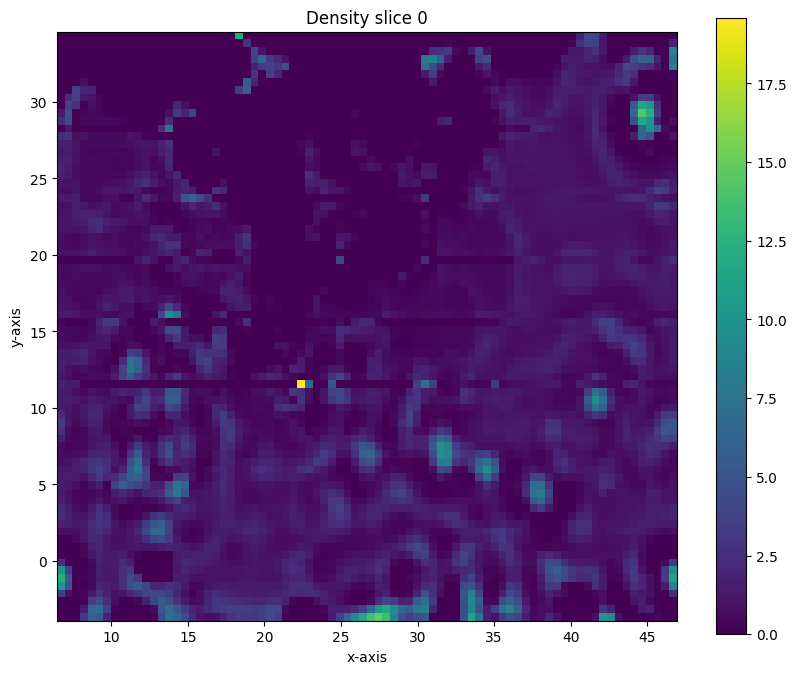

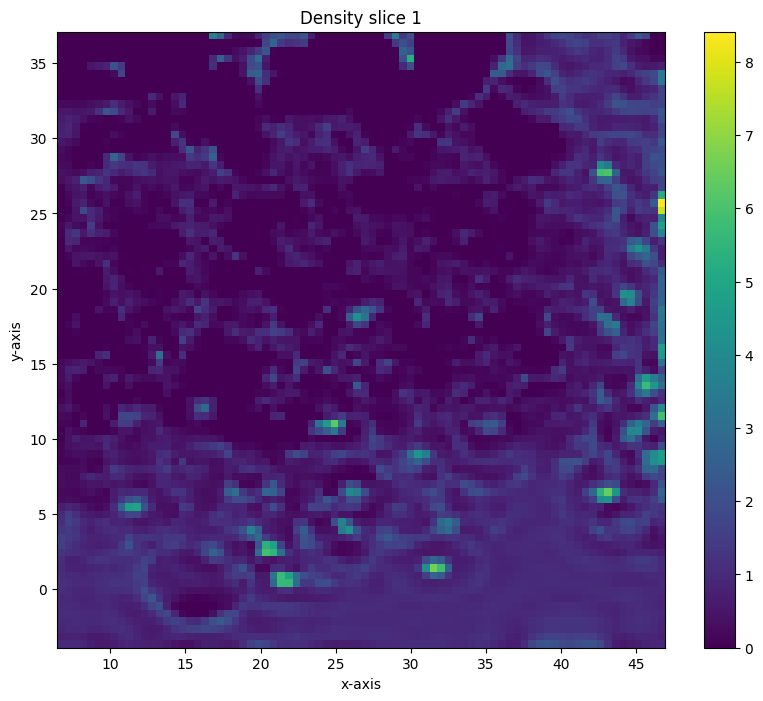

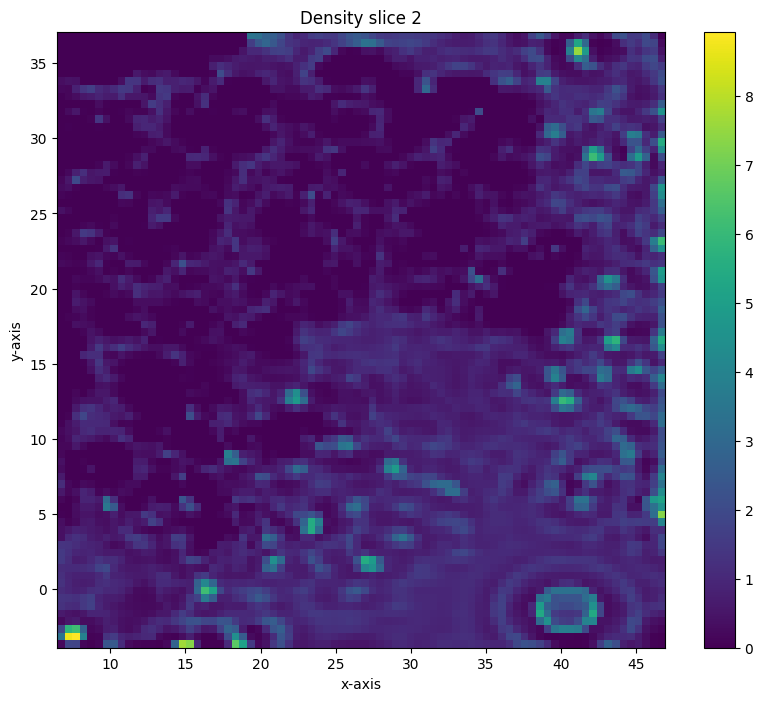

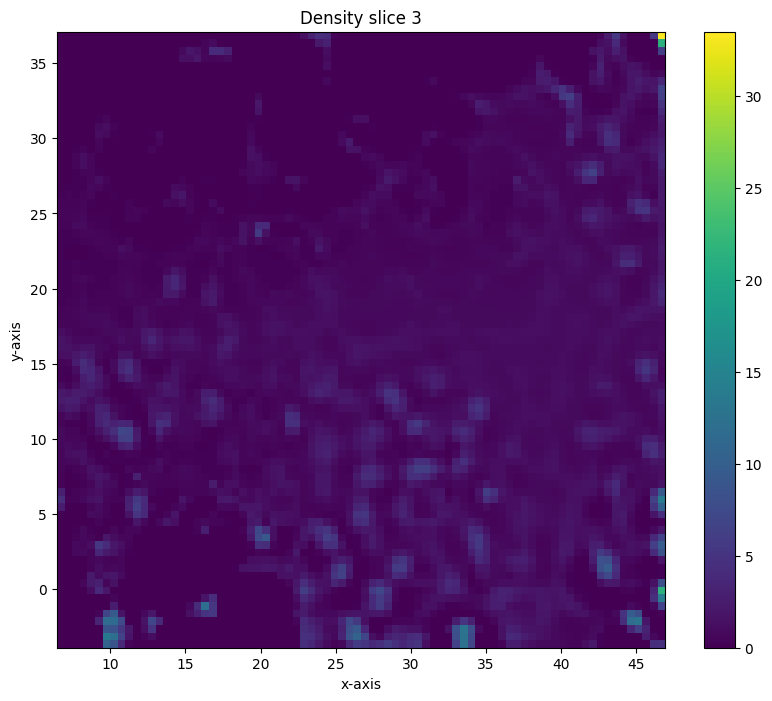

In [9]:
for c, canvas in enumerate(canvases_1nnc):
    canvas.draw(title=f"Density slice {c}")

In [10]:
canvases_1nnc[0].canvas_rotation

array([[ 0.85355339,  0.        , -0.        ],
       [ 0.        ,  0.70710678,  0.5       ],
       [ 0.        , -0.5       ,  0.70710678]])

### A second example starting with a 3D-RISM density file.

In [11]:
grid_bd = density_file_to_grid("../data/3D-RISM_densities/bromoD/prot_3drism.O.1.dx")

In [12]:
print(density_origin(grid_bd))
print(density_point_boundaries(grid_bd))

[101.906 -26.182 -20.756]
[141.906  13.818  19.244]


Try slicing in the Y direction.

In [13]:
points_bd = np.array([[0, 5, 0], [1, 5, 0], [0, 5, -1]]) + np.array([density_origin(grid_bd)] * 3)
canvases_bd = density_slices_by_plane_and_offsets(grid_bd, points=points_bd, offsets=np.linspace(5, 30, 6, dtype=int))

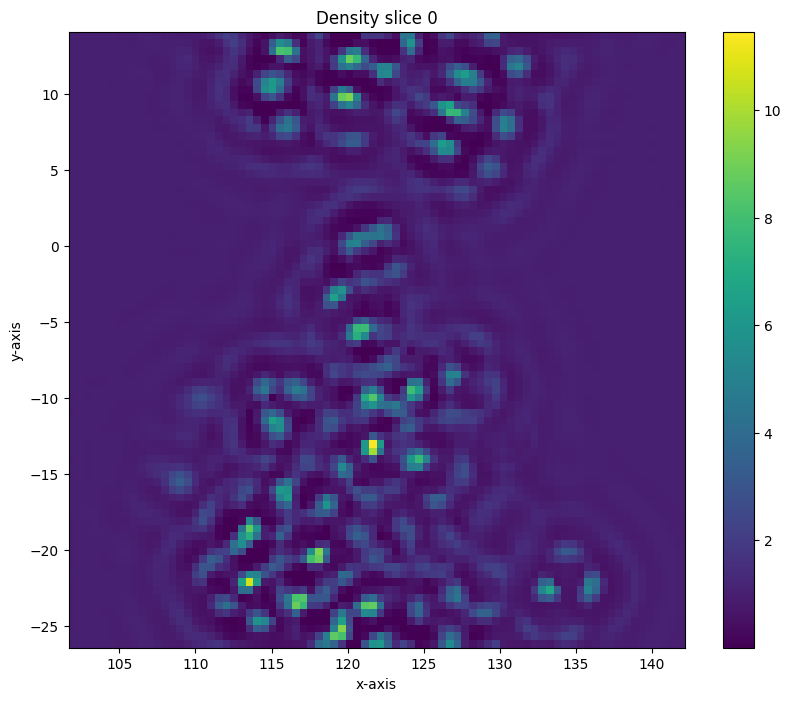

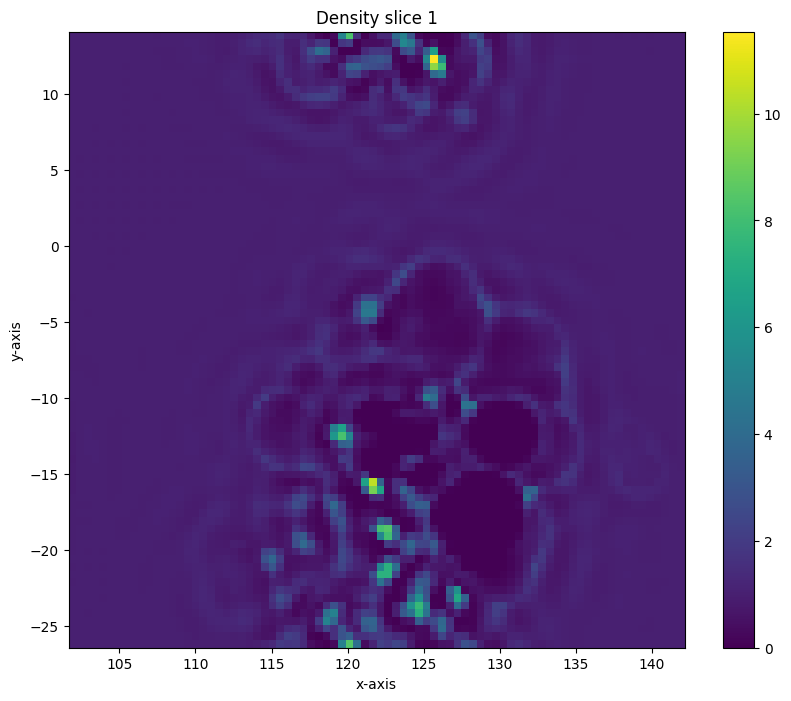

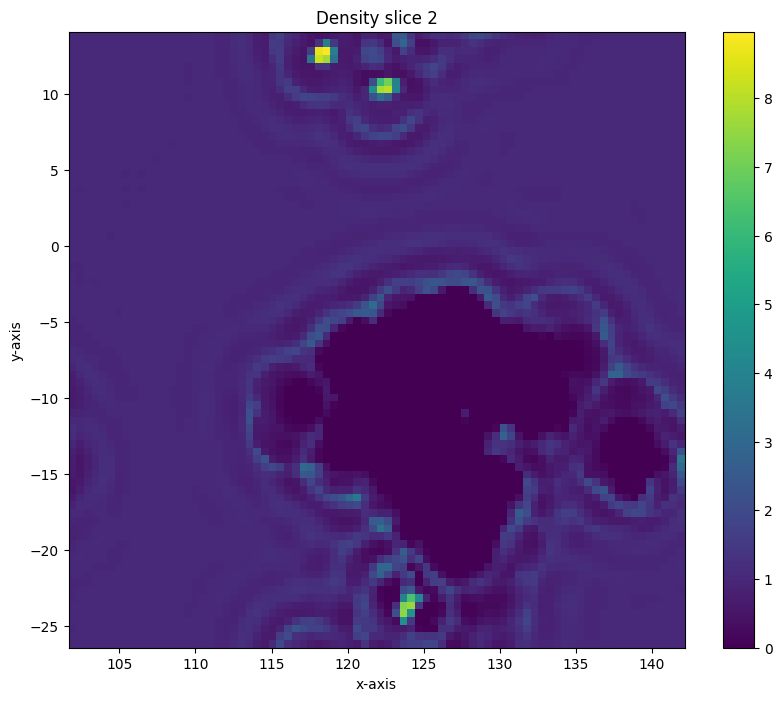

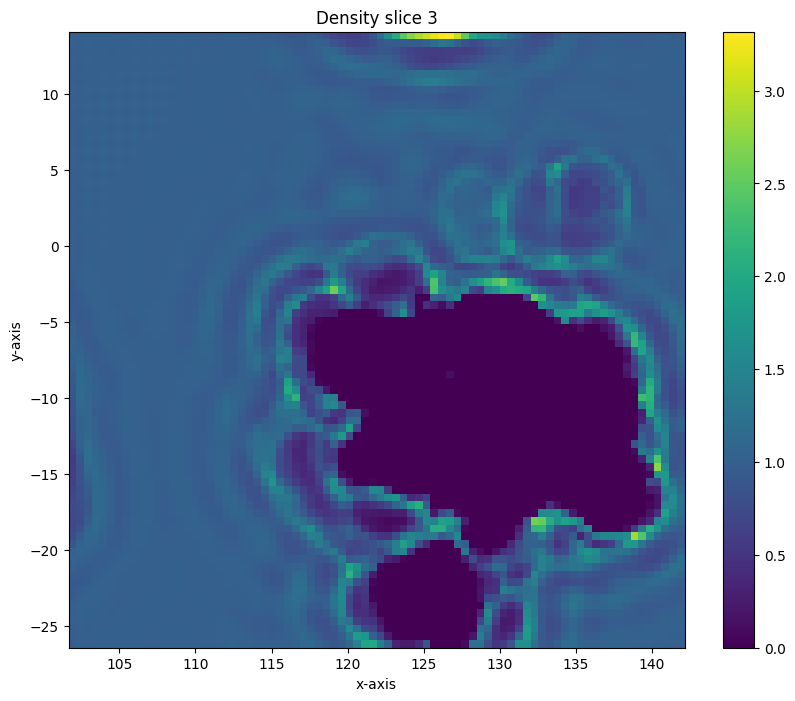

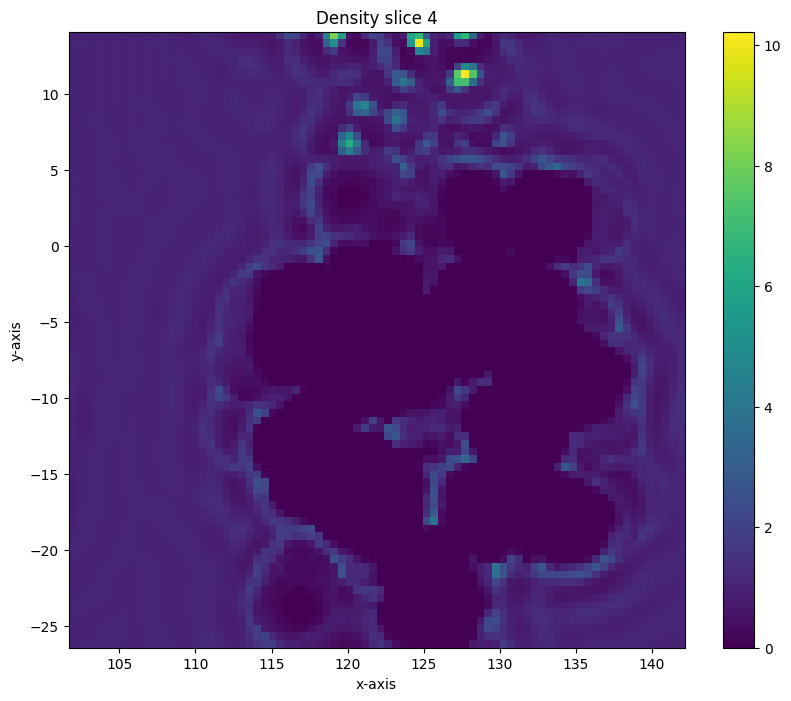

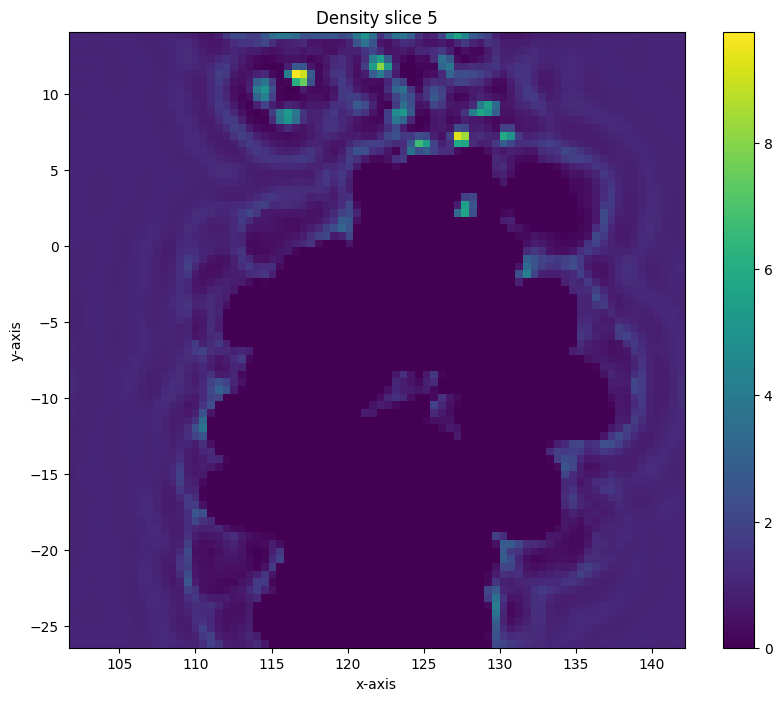

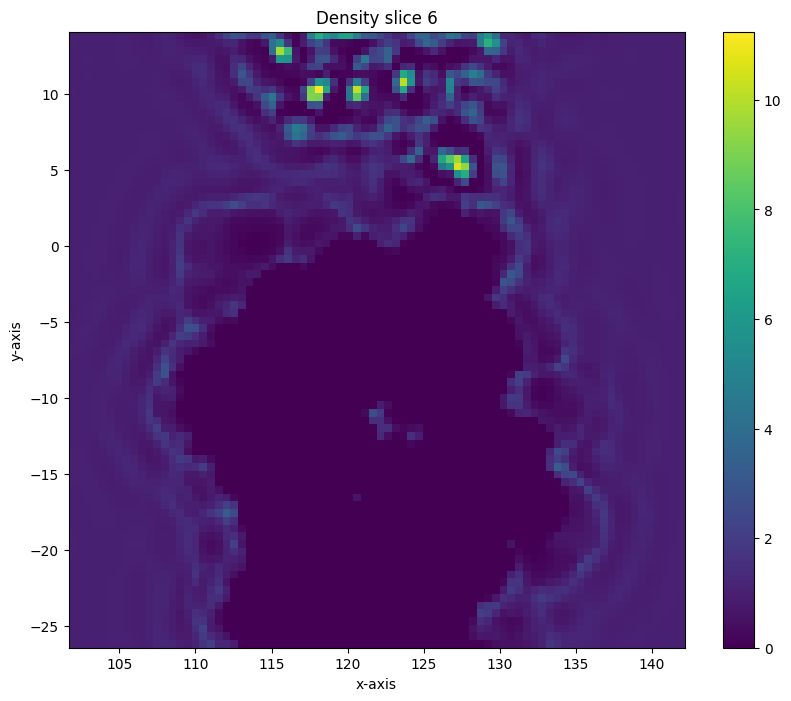

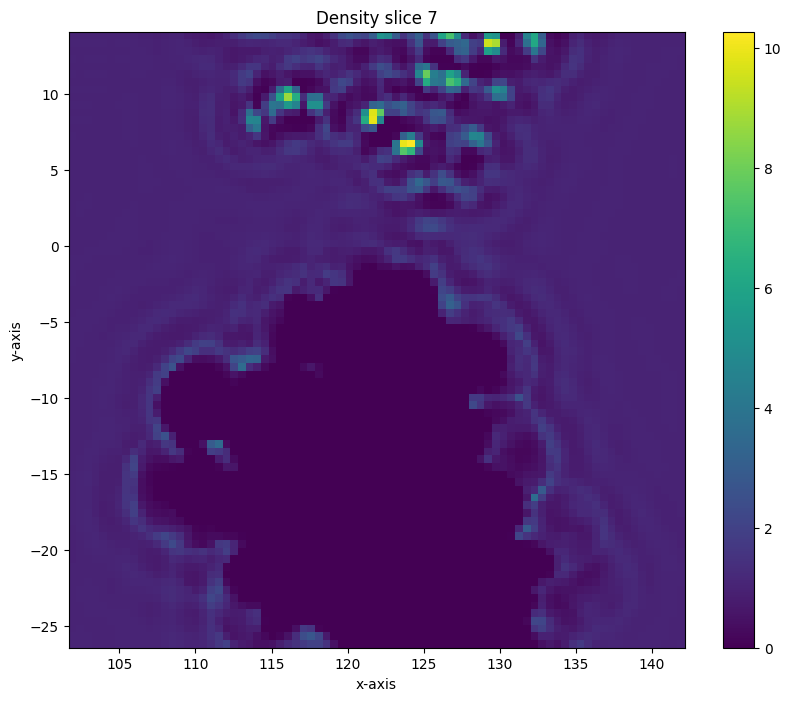

In [14]:
for c, canvas in enumerate(canvases_bd):
    canvas.draw(title=f"Density slice {c}")

### A third example starting with a 3D-RISM density file.

In [15]:
grid_dh = density_file_to_grid("../data/3D-RISM_densities/dehydratase/prot_3drism.O.1.dx")

In [16]:
print(density_origin(grid_dh))
print(density_point_boundaries(grid_dh))

[ -9.293  -6.514 -10.821]
[30.707 33.486 29.179]


Try slicing in the X direction.

In [17]:
points_dh = np.array([[8, 0, 0], [8, 1, 0], [8, 0, 1]]) + np.array([density_origin(grid_dh)] * 3)
canvases_dh = density_slices_by_plane_and_offsets(grid_dh, points=points_dh, offsets=np.linspace(8, 28, 3, dtype=int))

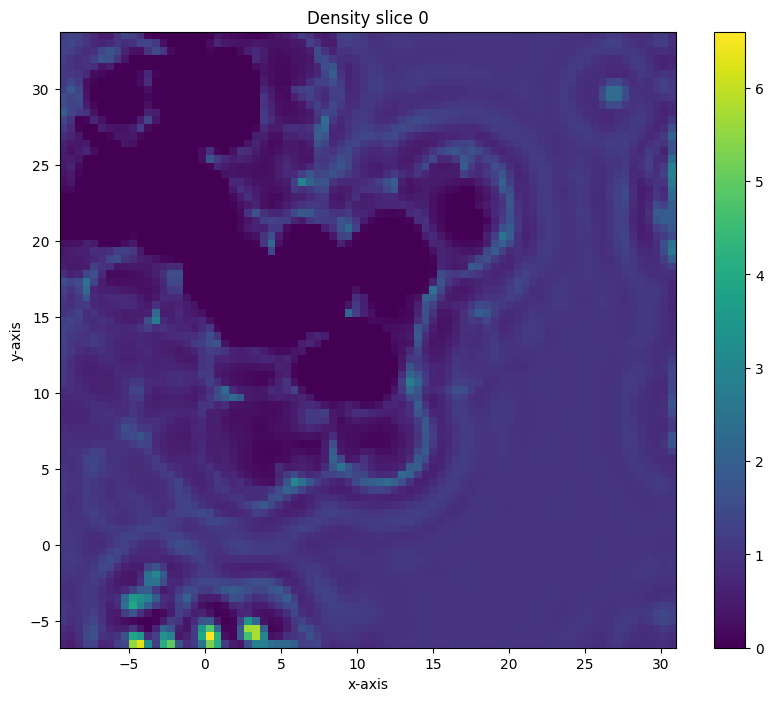

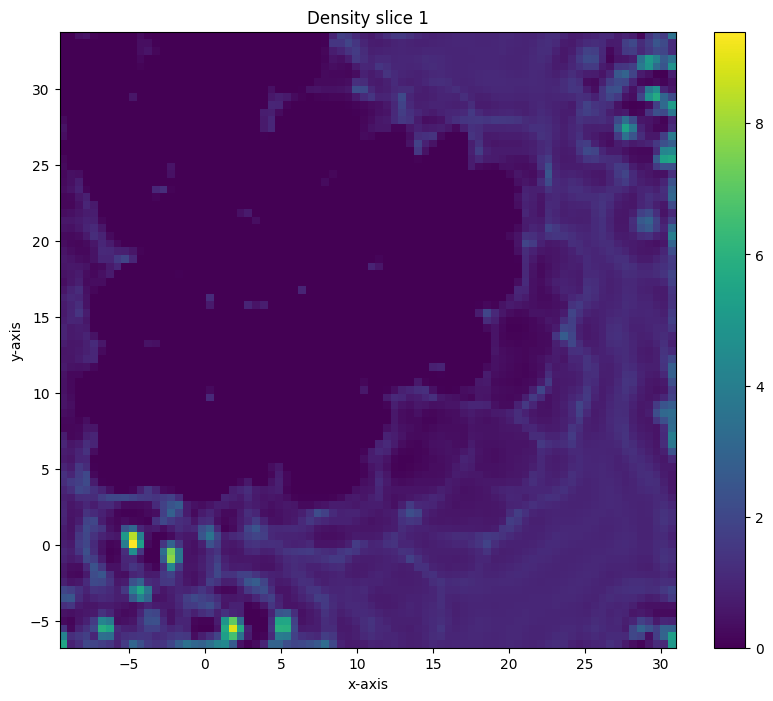

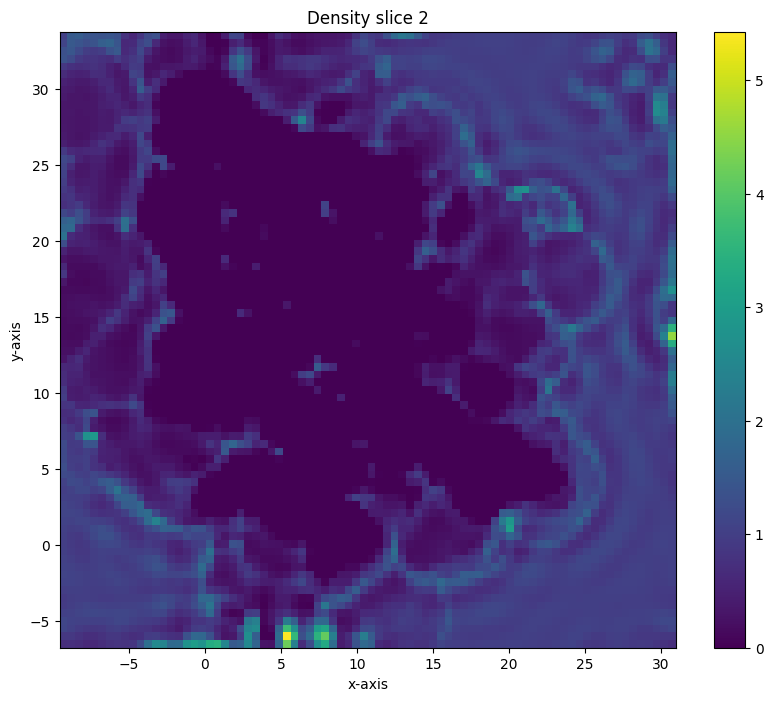

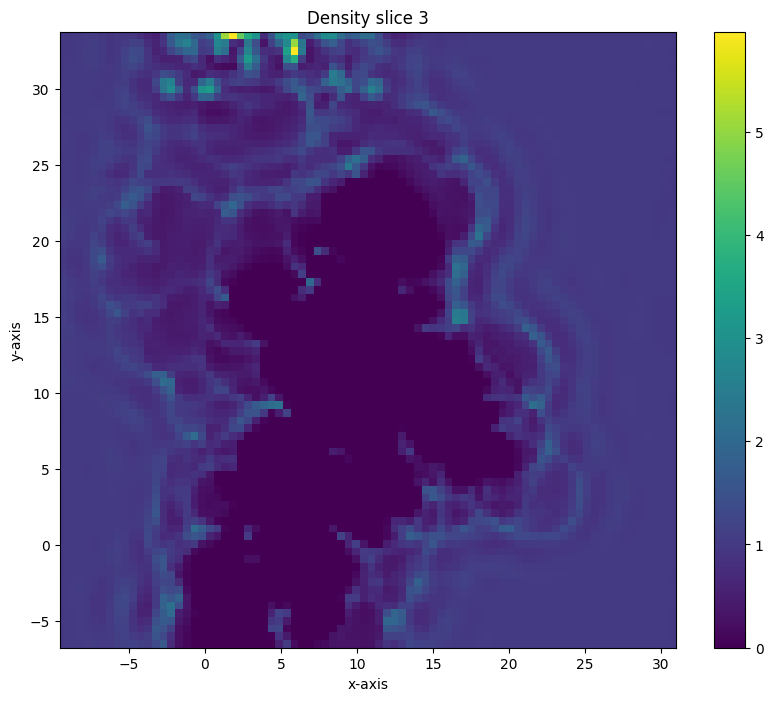

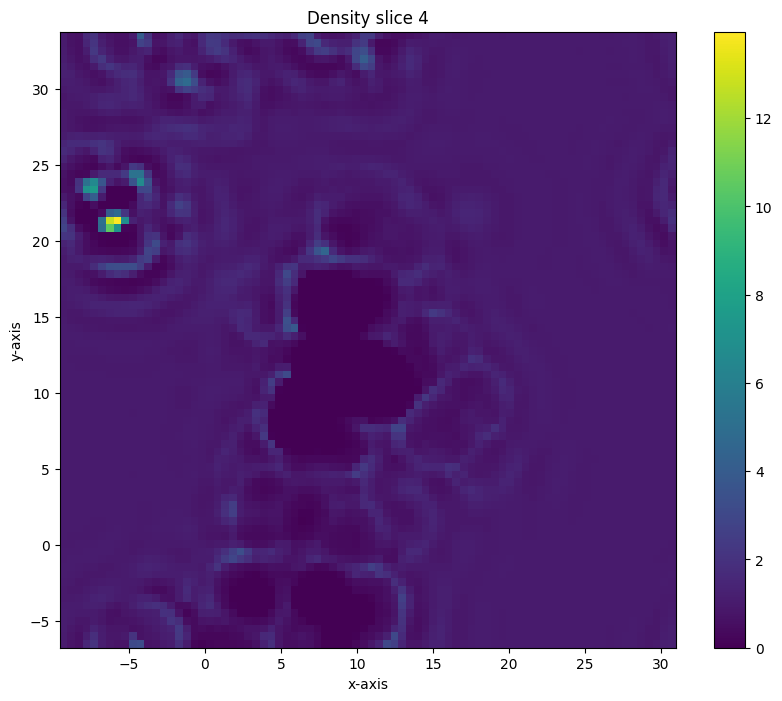

In [18]:
for c, canvas in enumerate(canvases_dh):
    canvas.draw(title=f"Density slice {c}")

In [26]:
# AQUAPOINTING

from pulser import Register
from pulser.devices import MockDevice, AnalogDevice
from pulser_simulation import QutipBackend
import pickle

from aquapointer import analog, processor
# import registers
path = "../registers/"
basename = "position_"
positions = []
registers = []
d_list = [-1.0, -0.5, 0.0, 0.5, 1.0, 1.5]
for i in range(len(d_list)):
    with open(f'../registers/position_{i}.npy', 'rb') as file_in:
        pos = np.load(file_in)
    positions.append(pos)
    registers.append(Register.from_coordinates(pos)) # this is to create a Pulser register object

basename = "rescaled_position_"
rescaled_positions = []
for i in range(len(d_list)):
    with open(f'../registers/rescaled_position_{i}.npy', 'rb') as file_in:
        res_pos = np.load(file_in)
    rescaled_positions.append(res_pos)
# choose the maximum detuning allowed
max_det = AnalogDevice.channel_objects[0].max_abs_detuning-1

# choose a blockade radius (in micrometers)
# which in turns defines a Rabi frequency
brad = 7
omega = AnalogDevice.rabi_from_blockade(brad)

# choose a pulse duration
T = 3000

pulse_settings = processor.PulseSettings(brad=brad, omega=omega, pulse_duration=T, max_det=max_det)
processor_configs = [processor.AnalogProcessor(device=MockDevice, pos=pos, pos_id=p, pulse_settings=pulse_settings) for p, pos in enumerate(positions)]

In [27]:
def executor(pulse_seq, num_samples):
    sim = QutipBackend(pulse_seq)
    res = sim.run()
    return res.sample_final_state(num_samples)

In [31]:
test_water_postions = analog.find_water_positions(canvases, executor, processor_configs)
print(test_water_postions)

[array([38.08640506, 20.64479747]), array([42.64336709, 28.74606329]), array([18.84589873, 15.07517722]), array([42.64336709, 28.74606329]), array([26.94716456, 12.54353165]), array([36.06108861, 23.17644304])]
